# Imports

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})
from matplotlib.colors import LogNorm, SymLogNorm

In [4]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

In [5]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
# from cf_analysis import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth, kde, pcalearn
from pcalearn import PCAYJ

# from cf_analysis import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression

import yjtransform as yjt


# Setup

In [6]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])           
            
    

In [7]:
# data = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
# data = data[data['Year'] <=2005]
# years = data['Year'].unique()
# # Tf = years[years <=2005]
# sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
# costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']    

# statesid = data['LocationAbbr'].unique()
# statesales, statecosts = {}, {}
# for ss in statesid:
#     statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
#     statecosts[ss] = costs[costs['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
# sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
# taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
# controlstates = list(set(statesid) - set(sskip))


# controls = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])
# # controls = np.array([statesales[ss] for ss in controlstates if ss!= 'CA'])
# treated = statesales['CA']

# X = np.array([statesales[ss] for ss in statesid ])

# # ncd = 5
# # # Xraw = np.array([statesales[i] for i in statesales.keys()])
# # Xraw = np.array([statesales[i] for i in controlstates])
# # Xrawmean = Xraw.mean(axis=0)
# # Xraw -= Xrawmean
# # pcad = PCA(ncd).fit(Xraw)
# # X = pcad.inverse_transform(pcad.transform(Xraw))

# N, T = X.shape[0], X.shape[1]
# T0 = 18
# itreated = 4
# t = np.arange(T)

In [169]:
# x0 = 18
# xx = np.linspace(0, x0)
# xx2 = np.linspace(0, 2*x0)
# plt.plot(xx2, np.cos(xx2%(2*x0)*np.pi/x0))
# plt.plot(xx2, np.cos(2*(xx2%(2*x0))*np.pi/x0))
# plt.plot(xx2, np.sin(xx2%(x0)*np.pi/x0))
# plt.plot(xx2, np.sin(2*(xx2%(x0))*np.pi/x0))
# # plt.plot(xx, np.sin(xx*np.pi/x0))
# # plt.plot(xx, np.sin(xx*np.pi/x0))

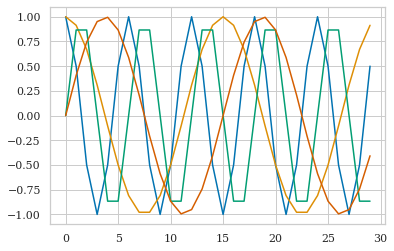

In [263]:
# def tmp(T, cosfreq=[0.2, 0.5], sinfreq=[0.2, 0.5]):
#     tt = np.arange(T)
#     factors = []
#     for cc in cosfreq:
#         cc *= T
#         factors.append(np.cos(2*(tt%cc) * np.pi / cc))
#     for cc in sinfreq:
#         cc *= T
#         factors.append(np.sin(2*(tt%cc) * np.pi / cc))
#     factors = np.array(factors)
#     return factors

# ff = tmp(30)
# plt.plot(ff.T)

In [513]:
class SineCosSim():
    
    def __init__(self, seed=100, cosfreq = [0.5, 1.], sinfreq = [0.3, 0.8],):
        np.random.seed(seed)
        self.cosfreq = cosfreq
        self.sinfreq = sinfreq
#         self.lnt0 = lnt0
#         self.lnt1 = lnt1
#         self.lt0 = lt0
#         self.lt1 = lt1
#         self.w0 = w0 * (self.lt0 - self.lnt0)
        
    
    def generate(self, Nco, Ntr, T, T0,  loadings='same', noise=1, phases=None, monoamp=1, fix=1):
        
        controlfix = np.random.uniform(0, fix, Nco).reshape(-1, 1)
        treatmentfix = np.random.uniform(0, fix, Ntr).reshape(-1, 1)
        tt = np.arange(T)
        controlmono = monoamp*controlfix * tt/T * np.exp(-tt/T)
        treatmentmono = monoamp*treatmentfix * tt/T * np.exp(-tt/T)
        
        factors = []
        for cc in self.cosfreq:
            cc = cc*T
            if phases is not None: phase = np.random.uniform(0, np.pi)
            else: phase = 0
            factors.append(np.cos(2*(tt%cc) * np.pi / cc + phase))
        for cc in self.sinfreq:
            cc = cc*T
            if phases is not None: phase = np.random.uniform(0, np.pi)
            else: phase = 0
            factors.append(np.sin(2*(tt%cc) * np.pi / cc  + phase))
        factors = np.array(factors)
        
        if loadings is 'same' or type(loadings) == np.ndarray: 
            controlloads = np.random.uniform(size=factors.shape[0]).reshape(1, -1)
            treatmentloads = controlloads.copy()
        elif loadings is 'diff' :
            controlloads = np.random.uniform(size=factors.shape[0]).reshape(1, -1)
            treatmentloads = np.random.uniform(size=factors.shape[0]).reshape(1, -1)
        else: 
            controlloads = np.random.uniform(size=Nco*factors.shape[0]).reshape(Nco, -1)
            treatmentloads = np.random.uniform(size=Ntr*factors.shape[0]).reshape(Ntr, -1)

        
        Y0 = np.dot(controlloads, factors) + controlmono + controlfix + np.random.normal(scale=noise, size=Nco*T).reshape(Nco, T)
        Y1 = np.dot(treatmentloads, factors) + treatmentmono + treatmentfix +  np.random.normal(scale=noise, size=Ntr*T).reshape(Ntr, T)

        treatement = np.zeros([Ntr, T])
        treatement[:, T0:] = np.arange(T-T0).reshape(1, -1)*Y1.std()*2/(T-T0) + np.random.normal(scale=noise, size=Ntr*(T-T0)).reshape(Ntr,T-T0)

        data = np.concatenate([Y1 + treatement, Y0])
        cf = np.concatenate([Y1, Y0])

        return data, cf
        


In [227]:
class DGPXu():
    
    def __init__(self, seed=100, w0=0.8, lnt0=-3**0.5, lnt1=3**0.5, lt0=3**0.5, lt1=3**1.5):
        np.random.seed(seed)
        self.lnt0 = lnt0
        self.lnt1 = lnt1
        self.lt0 = lt0
        self.lt1 = lt1
        self.w0 = w0 * (self.lt0 - self.lnt0)
        
    
    def generate(self, Nco, Ntr, T, T0, nfactors, loadvariates = np.array([1, 3]), fixedeff=False, noise=1):
        
        factors = np.random.normal(size=T*nfactors).reshape(nfactors, T)
        
        controlloads = np.random.uniform(self.lnt0, self.lnt1, size=Nco*nfactors).reshape(Nco, nfactors)
        #treatmentloads = np.random.uniform(self.lnt0, self.lnt1, size=Ntr*nfactors).reshape(Ntr, nfactors)
        treatmentloads = np.random.uniform(self.lt0 - self.w0, self.lt1 - self.w0, size=Ntr*nfactors).reshape(Ntr, nfactors)
        if fixedeff: 
            controlfix = np.random.uniform(self.lnt0, self.lnt1, size=Nco).reshape(Nco, 1)
            #treatmentfix  = np.random.uniform(self.lnt0, self.lnt1, size=Ntr).reshape(Ntr, 1)
            treatmentfix  = np.random.uniform(self.lt0 - self.w0, self.lt1 - self.w0, size=Ntr).reshape(Ntr, 1)            
        else: controlfix, treatmentfix = 0, 0
            
        
        controlvariates, treatmentvariates = np.zeros([Nco, T]), np.zeros([Ntr, T])
        try: 
            for i, l in enumerate(loadvariates):
                controlvariates += l* (1 + np.dot(controlloads, factors) + controlloads.sum(axis=-1).reshape(Nco, 1) + factors.sum(axis=0).reshape(1, -1) + np.random.normal(size=Nco*T) .reshape(Nco, T))
                treatmentvariates += l*(1 + np.dot(treatmentloads, factors) + treatmentloads.sum(axis=-1).reshape(Ntr, 1) + factors.sum(axis=0).reshape(1, -1) + np.random.normal(size=Ntr*T) .reshape(Ntr, T))
        except : pass
        
        Y0 = np.dot(controlloads, factors) + controlvariates + controlfix + np.random.normal(scale=noise, size=Nco*T).reshape(Nco, T)
        Y1 = np.dot(treatmentloads, factors) + treatmentvariates + treatmentfix + np.random.normal(scale=noise, size=Ntr*T).reshape(Ntr, T)

        treatement = np.zeros([Ntr, T])
        treatement[:, T0:] = np.arange(T-T0).reshape(1, -1) np.random.normal(scale=noise, size=Ntr*(T-T0)).reshape(Ntr,T-T0)

        data = np.concatenate([Y1 + treatement, Y0])
        cf = np.concatenate([Y1, Y0])

        return data, cf
        


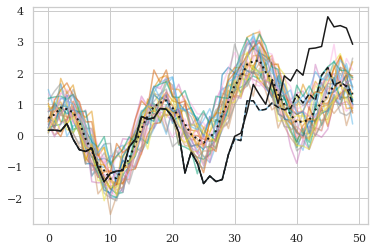

In [527]:
Ntr = 1
N = 30
T0 = 30
T = 50
itreated = 0
t = np.arange(T)

# xu = DGPXu(10)
# X, cf = xu.generate(N - Ntr, Ntr, T, T0, 10, fixedeff=True)
sinecos = SineCosSim(100)
X, cf = sinecos.generate(N - Ntr, Ntr, T, T0,  
                         loadings='diff', noise=0.3, phases='random')


controls = X[1:].copy()
treated = X[0].copy()
truth = cf[0].copy()

plt.plot(cf.T, alpha=0.5);
plt.plot(treated, 'k')
plt.plot(cf[0], 'k--')
plt.plot(cf.mean(axis=0), 'k:', lw=2)


In [529]:
dgpdict ={
    'seed':100,
    'cos':sinecos.cosfreq,
    'sine':sinecos.sinfreq,
    'loadings':'diff',
    'noise':0.3,
    'monoamp':1,
    'fix':1,
    'phases':'random'
}
dgpdict

{'seed': 100,
 'cos': [0.5, 1.0],
 'sine': [0.3, 0.8],
 'loadings': 'diff',
 'noise': 0.3,
 'monoamp': 1,
 'fix': 1,
 'phases': 'random'}

In [424]:


# years = t           
# xplot = years.copy()            

# data = pd.read_csv('../basque.csv')
# years = data['year'].unique()
# T0 = np.where(years == 1970)[0][0]
# years = years[:2*T0]
# gdp = data['gdpcap'].values.reshape(18, -1)
# gdp = gdp[1:, :2*T0]
# treated = gdp[-2]
# rr = data['regionname'].unique()[-2]
# controls = np.append(gdp[:-2], gdp[-1:], axis=0)

# X = gdp.copy()
# N, T = X.shape[0], X.shape[1]
# t = np.arange(T)
# itreated = 15



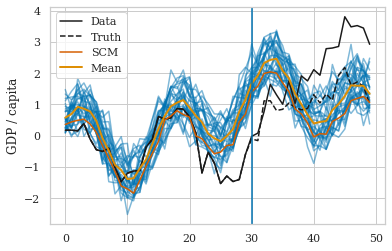

In [531]:
plt.plot(t, controls.T, 'C0', alpha=0.5)
plt.plot(t, treated, 'k', label='Data')
plt.plot(t, truth, 'k--', label='Truth')
plt.plot(t, synth.fit(controls, treated, T0)[0],'r', label='SCM')
plt.plot(t, controls.mean(axis=0), 'C1', lw=2, label='Mean')
# plt.plot(pcad.inverse_transform(pcad.transform((treated-Xrawmean).reshape(1, -1))).flatten()+Xrawmean)
# plt.plot(Xraw[4]+Xrawmean)
# plt.plot(X[4]+Xrawmean)
plt.ylabel('GDP / capita')
plt.axvline(t[T0])
plt.legend()
plt.show()



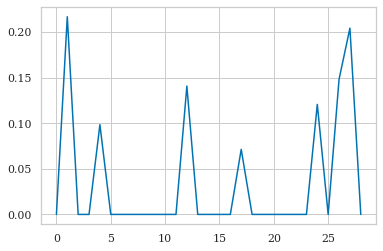

In [533]:
plt.plot(synth.fit(controls, treated, T0)[1])

In [112]:
# T = 100
# ncd = 10
# t = np.arange(0, T)
# T0 = 60
# N = 50


# X = np.random.normal(10, 2, N*T).reshape(N, T)
# X = X + np.random.normal(0, N, N).reshape(-1, 1)
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1).reshape(-1, 1)*t/T
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)*t**2/T * np.exp(-2*t/T)
# # X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.pi/T* t* np.random.normal(size=N).reshape(-1, 1)) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(0)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(1)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(2)*np.pi/T* t) 

# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(3)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(4)*np.pi/T* t) 
# Xraw = X.copy()
# pcad = PCA(ncd).fit(Xraw)
# X = pcad.inverse_transform(pcad.transform(Xraw))

# itreated = np.random.randint(N)
# controls = np.concatenate([X[:itreated], X[itreated+1:]])
# treated = X[itreated]

# fig, ax = plt.subplots(1, 2, figsize = (8, 4))
# ax[0].plot(Xraw.T)
# ax[1].plot(controls.T, 'b', alpha=0.5)
# ax[1].plot(treated, 'r', alpha=1)
# plt.show()
# plt.plot(pcad.components_.T);
# plt.show()
# plt.plot(np.linalg.svd(Xraw)[1], 'o');
# plt.semilogy()
# plt.show()

# SCM

In [534]:

scmfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, wts = synth.fit(xx, yy, T0)
        
    scmfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)
    
    
    

scmfitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    ##
    ##
    mmx, mmy = xxc[:, :T0].mean(axis=1), yyc[:T0].mean()
    xx = xxc - mmx.reshape(-1, 1)
    yy = yyc - mmy
    
    yp, wts = synth.fit(xx, yy, T0)    
    yp += mmy
    
    scmfitsres[ss] = GetObject(controls=xxc, treated=yyc, pred=yp, wts=wts)    

# Fourier Anlaysis

[]

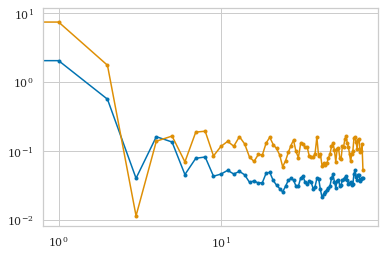

In [535]:
gl = glearn.GLearn(controls, padl=T, padr=T, stdscale=False)
plt.plot(gl.pkraw, marker='.')
plt.plot(gl.pkprior, marker='.')
plt.loglog()

In [536]:
# glpred, glerr, glcov = gl.fit(treated, T0)

# bins = 30 
# normed = False
# # plt.hist((controls - means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist((gl.controls-means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist(gl.controlsg.flatten(), bins=bins, normed=normed, label='Transformed', alpha=0.6, color='C1')
# plt.legend()
# plt.show()
# # plt.hist(gca.controls.flatten())
# plt.plot(t, treated,'k')
# plt.plot(t, truth,'k--')
# plt.errorbar(t, scmfits[0].pred)
# plt.errorbar(t, glpred, glerr, label='GL')
# plt.plot(t, means)


# PCA

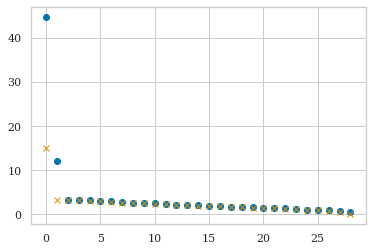

In [544]:
plt.plot(np.linalg.svd(controls)[1], 'o')
plt.plot(np.linalg.svd(controls - controls.mean(axis=0))[1],'x')

In [538]:
xx = controls.copy()
means = xx.mean(axis=0)
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
mmx = xx[: , :T0].mean(axis=1)
mmy = yy[:T0].mean()
xx -= mmx.reshape(-1, 1)
yy -= mmy
##
i = 0 
ncomp = tools.approximate_rank(xx-means , t=0.99)
# ncomp = tools.approximate_rank(xx - means, t=0.999)
# ncomp = 10
# ncomp = 4
print(ncomp)
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5


17


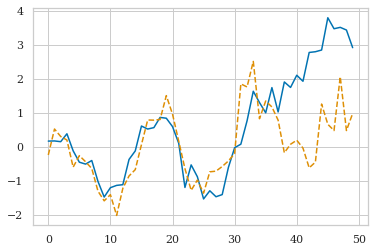

In [539]:

pclT0 = pcalearn.PCAlearn(xx[:, :T0], ncomp, stdscale=False, normalization='center')
pcaT0 = pclT0.pca

##
ypca, pp = pcl.fit(yy.flatten(), T0, regwt=None, verbose=True)
ypca += means
ypca += mmy
plt.plot(xplot, treated, label='data')
plt.plot(xplot, ypca , '--')
# plt.plot(xplot, yy + means, label='data')
# plt.plot(xplot, means, ':')
# plt.plot(xplot, ypcar, ":", lw=3, alpha=0.5)
# plt.plot(xplot, ypcar2, ':', lw=3, alpha=0.5)


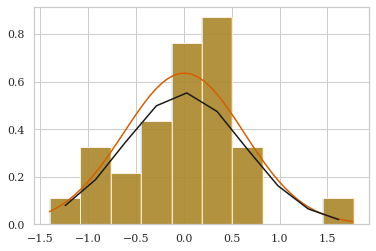

In [540]:
nbins=10
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 1].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
ptt = yjt.get_transform(tt)
# plt.plot(ttx, yjt.invtransform(ttx, ptt))
ttx = np.linspace(tt.min(), tt.max())
qq = yjt.getpdf(ttx, ptt)
plt.plot(ttx, qq, 'r')

y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.7, bins=nbins, density=True)
x_ = (x_[1:] + x_[:-1])/2.
pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    
plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, *pp, rety=True), 'k')


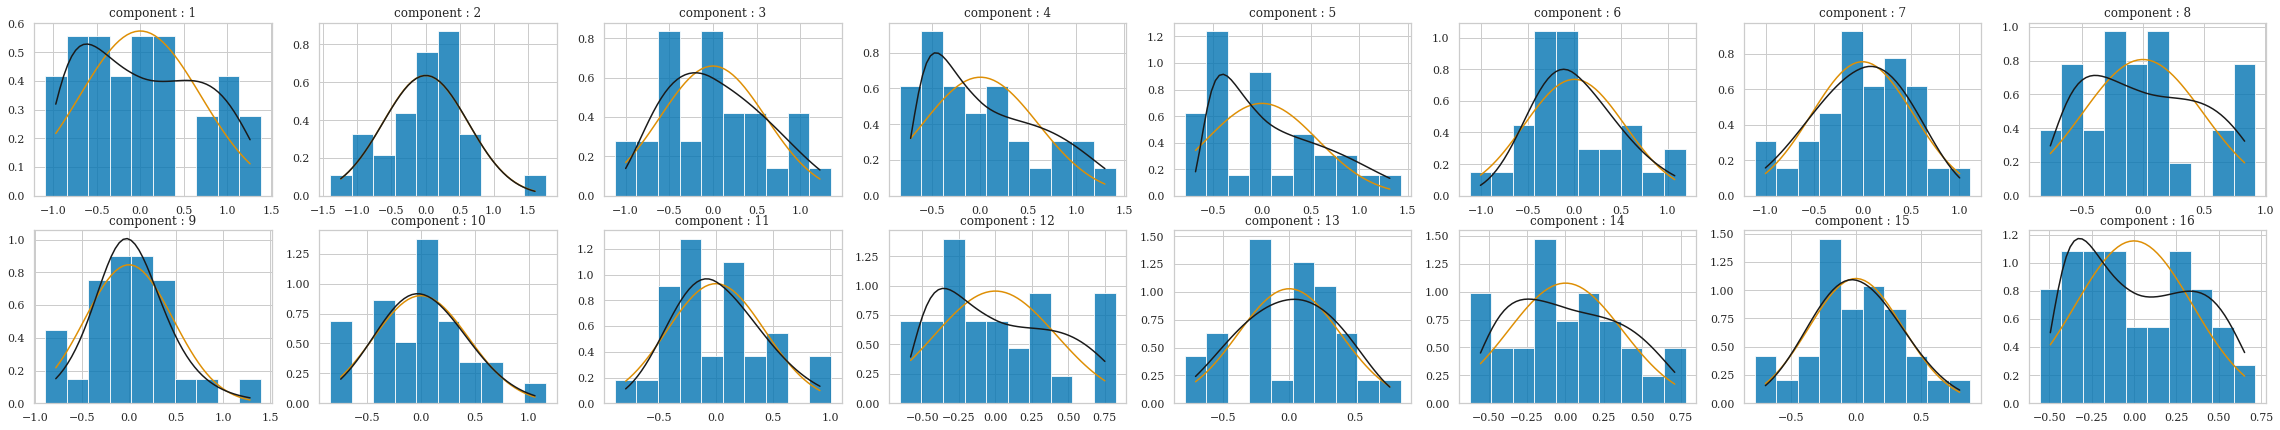

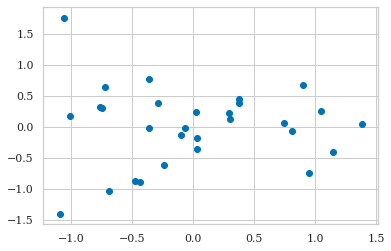

In [541]:
nbins = 10 
normed = True

# # ncomp = 10
# # xx = controls.copy()
# # pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
# # pca = pcl.pca
# xxt = pca.transform(pcl.normalize(xx))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*5, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxt.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxt.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    ax[ia].set_title("component : %d"%(ia+1))
    pyj = yjt.get_transform(xxt.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
plt.show()
plt.scatter(xxt[:, 0], xxt[:, 1])
plt.show()

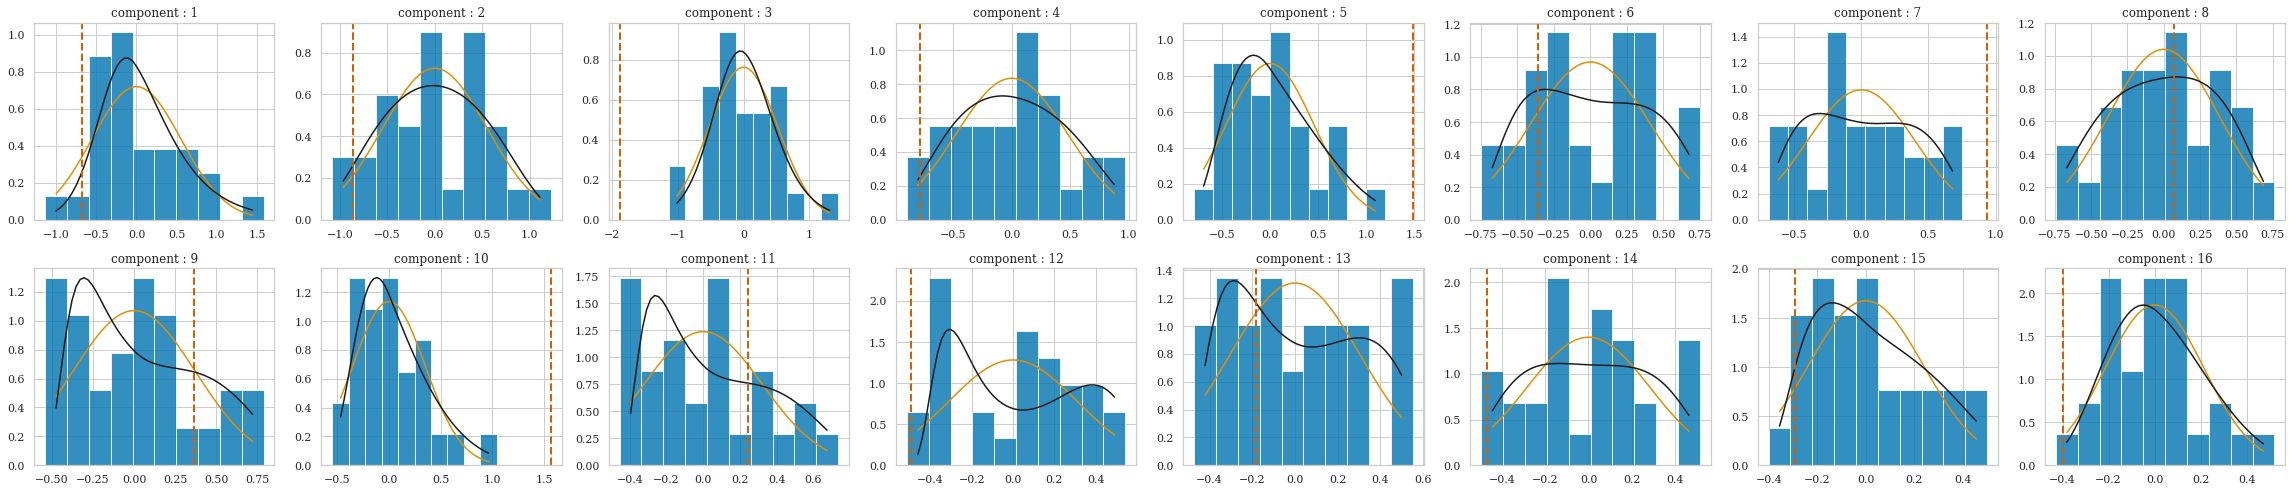

In [542]:
xxT0 = pcaT0.transform(pclT0.normalize(xx[:, :T0]))
ppT0 = pcaT0.transform(pclT0.normalize(treated[:T0]).reshape(1, -1))[0]

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))

# ppT0 = pcaT0.transform(treated[:T0].reshape(np.newaxis, 1))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*4, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxT0.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxT0.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    
    pyj = yjt.get_transform(xxT0.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
    ax[ia].axvline(ppT0[ia], color='r', lw=2, ls="--")
    ax[ia].set_title("component : %d"%(ia+1))

plt.tight_layout()
plt.show()

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))
# ax[0].scatter(xxT0[:, 0], xxT0[:, 1])
# ax[0].plot(ppT0[0], ppT0[1], 'rx', markersize=10, lw=2)
# ax[0].set_xlabel(0)
# ax[0].set_ylabel(1)

# ax[1].scatter(xxT0[:, 1], xxT0[:, 2])
# ax[1].plot(ppT0[1], ppT0[2], 'rx', markersize=10)
# ax[1].set_xlabel(1)
# ax[1].set_ylabel(2)

# ax[2].scatter(xxT0[:, 2], xxT0[:, 1])
# ax[2].plot(ppT0[2], ppT0[1], 'rx', markersize=10, lw=2)
# ax[2].set_ylabel(2)
# ax[2].set_xlabel(1)
# plt.tight_layout()
# plt.show()

In [475]:
pcafits95 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
    pcafits95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)



    
pcafits99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
    pcafits99[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)



pcafits999 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.999)
    ##0
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
    pcafits999[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)

    


svdfits99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncsvd = tools.approximate_rank(xx, t=0.99)
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    svdfits99[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp, nc=ncsvd)

    

In [476]:
pcafits95reg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 50), verbose=0, method='bfgs', dT=9)
    pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)

pcafits99reg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 50), verbose=0, method='bfgs', dT=9)
    pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)



# PCAYJ

[-3.76854886  3.09936989 -1.13837364 -1.40302083 -0.41609414]
      fun: 10.516580263685977
 hess_inv: array([[ 9.27491213e-02, -3.94026957e-02, -1.06225092e-03,
        -1.80348289e-02, -9.25395141e-02],
       [-3.94026957e-02,  2.24591930e-01, -3.86731250e-04,
        -6.13731589e-02, -1.49761568e-02],
       [-1.06225092e-03, -3.86731250e-04,  1.56192503e-03,
        -4.14690250e-05, -4.21764769e-04],
       [-1.80348289e-02, -6.13731589e-02, -4.14690250e-05,
         2.71041414e-02,  3.57034592e-02],
       [-9.25395141e-02, -1.49761568e-02, -4.21764769e-04,
         3.57034592e-02,  1.31683957e-01]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 175
      nit: 15
     njev: 25
   status: 0
  success: True
        x: array([-3.15128077,  2.27520792, -0.90970869, -1.43280883, -0.849392  ])
3.0559497557641384 -7.460630507921839


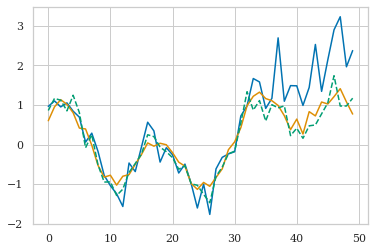

In [477]:
pcayj = PCAYJ(controls, 5, whiten=False)
ty, tp = pcayj.fit(treated, T0, verbose=2, method='bfgs')
# ty, tp = pcayj.fit(treated, T0, verbose=2, method='lbfgs')
# plt.plot(means, 'gray')
plt.plot(treated)
plt.plot(ty)
plt.plot(ypca, '--')


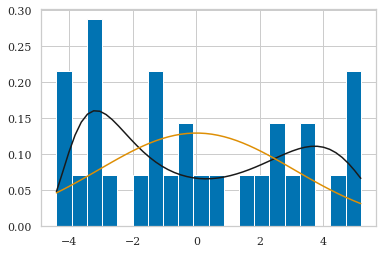

In [478]:
ii = 0
xdata = pcayj.control_wts[:, ii]
plt.hist(xdata, density=True, bins=20)
xplot = np.linspace( xdata.min(), xdata.max())
plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]), 'k')
ppg = tools.fitgausspdf(xdata)
plt.plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True))
# plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]))

In [479]:
pcafitsyj95 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
#     method = 'nelder-mead'
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    
    pcafitsyj95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)

print('pcafitsyj95 done')

pcafitsyj99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
#     method = 'nelder-mead'
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    
    pcafitsyj99[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)

print('pcafitsyj99 done')

# pcafitsyj999 = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.999)
#     ##
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     ##
#     method = 'nelder-mead'
# #     mehtod = 'lbfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
#     pcafitsyj999[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)




pcafitsyj95 done
pcafitsyj99 done


scmfits 0.5901373775998738
scmfitsres 0.6343822638181441
pca99 1.0415628605462466
pcafits95 0.8611802558322335
pcafits99reg 0.7694123027910648
pcafitsyj99 0.5915739686315005
pcafitsyj95 116.87443562373156
svdfits99 0.9392052330574983


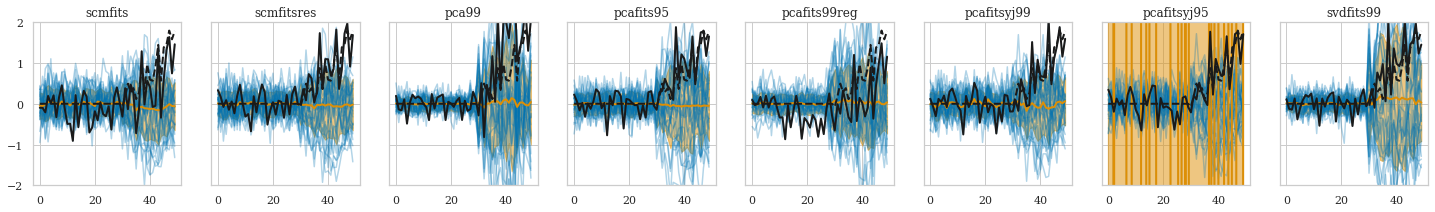

In [487]:
fig, ax = plt.subplots(1, 8, figsize=(25, 3), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
for j, fits in enumerate([scmfits, scmfitsres, pcafits99, pcafits95, pcafits99reg, pcafitsyj99, pcafitsyj95, svdfits99]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, X[itreated] - cf[itreated], 'k--', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)

In [481]:
xx = controls.copy()
means = xx.mean(axis=0)*1
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
# mmx = xx[: , :T0].mean(axis=1)*0
# mmy = yy[:T0].mean()*0
# xx -= mmx.reshape(-1, 1)
# yy -= mmy
##
pcapreds = {}
pcapredsyj = {}
pcapredsreg = {}
svdpreds = {}

i = 0 
# for ncomp in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
ncomps = np.unique(np.linspace(1, tools.approximate_rank(X, 0.999), 10).astype('int'))
if ncomps[-1] < 10: ncomps = np.linspace(1, 10, 10)
for ncomp in ncomps:
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    ypca, pp = pcl.fit(yy.flatten(), T0, regwt=None, verbose=True)
    ypca += means
    pcapreds[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp)
    
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    ypca, pp = pcl.fit(yy.flatten(), T0, regwt=np.logspace(-4, 0), verbose=True, method='bfgs')
    ypca += means
    pcapredsreg[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp)
    
    pcayj = PCAYJ(xx, ncomp, whiten=False)
    ypcayj, ppyj = pcayj.fit(yy.flatten(), T0, verbose=0, method='bfgs')
    ypcayj += means
    pcapredsyj[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj, pcl=pcayj, fitp=ppyj, nc=ncomp)

    ##
    svl = SVDlearn(controls.copy(), stdscale=False, normalization=None)
    yp, pp = svl.fit(treated.copy(), T0, ncomp, verbose=False)
    svdpreds[ncomp] = GetObject(controls=controls.copy(), treated=treated.copy(), svl=svl, pred=yp, fitp=pp, nc=ncomp)


min rms is at reg = 0.0001
min rms is at reg = 0.0036
min rms is at reg = 0.0043
min rms is at reg = 0.0001
min rms is at reg = 0.1842
min rms is at reg = 0.1842
min rms is at reg = 0.1526
min rms is at reg = 0.2223
min rms is at reg = 0.1265
min rms is at reg = 0.1526


# KDE

0.2782559402207126
17 10


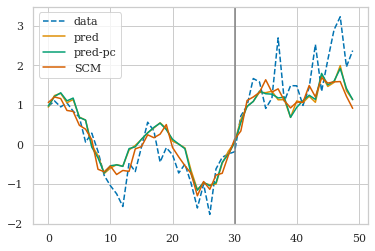

In [482]:
def get_ykde(gg, X1, X2, Y1, gamma=np.logspace(-3, 0, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde])
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) 
    return ykde, kde, wts
 

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(t, yyc, '--', label='data')
plt.plot(t, yp, label='pred')
# plt.plot(years, means, 'k--', label='means')


nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
if nc1 <=1 : nc1 +=1 
if nc2 <=1 : nc2 +=1 
print(nc1, nc2)
# nc1, nc2 = 3, 3 
p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
XX1, XX2 = p1.transform(X1), p2.transform(X2)
YY1 = p1.transform(Y1.reshape(1,-1))
ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
y1, y2 = ykdep[:nc1], ykdep[nc1:]
yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
yp *= stds
yp += means
plt.plot(t, yp, label='pred-pc')

ypscm, wts = synth.fit(xx, yy, T0)
plt.plot(t, ypscm*stds + means, label='SCM')
plt.axvline(t[T0], color='gray')
plt.legend()

In [483]:
kdefitsvanilla =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitsvanilla[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

kdefitsmeans =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*0 + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitsmeans[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

kdefits =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefits[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)


kdefitspca99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitspca99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, pca=pca, nc=nc)

print('kdefitspca99 done')

kdefitspcawts99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
       
    kdefitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)

    
print('kdefitspcawts99 done')

    
kdefitspcawts995 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
#     nc1, nc2 = 3, 3 # tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    nc1, nc2 = tools.approximate_rank(X1, 0.995), tools.approximate_rank(X2, 0.995)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
        
    kdefitspcawts995[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)
    
print('kdefitspcawts995 done')

## KDE FITS RESIDUAL

kdefitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsres[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsres done')


kdefitsrespca99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()

    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsrespca99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsrespca99 done')

kdefitsrespcawts99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp +=  mmy
    yp *= stds
    yp += means
        
    kdefitsrespcawts99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)
    
        

kdefitspca99 done
kdefitspcawts99 done
kdefitspcawts995 done
kdefitsres done
kdefitsrespca99 done


scmfits 0.5901373775998738
scmfitsres 0.6343822638181441
kdefits 0.5364537461127008
kdefitspca99 0.5107360606174414
kdefitspcawts99 0.5384567764947792
kdefitsres 0.5642683506750831
kdefitsrespca99 0.5362354719932333
kdefitsrespcawts99 0.567299171284097


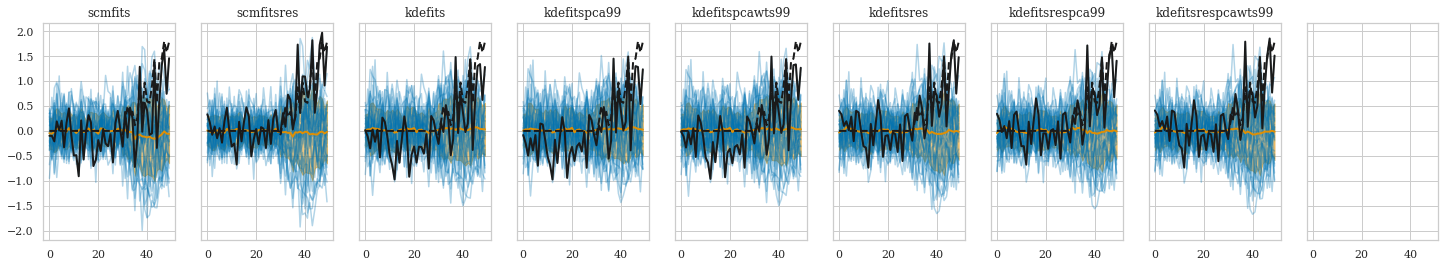

In [484]:
fig, ax = plt.subplots(1, 9, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'kdefits', 'kdefitspca99', 'kdefitspcawts99', 
          'kdefitsres', 'kdefitsrespca99', 'kdefitsrespcawts99']
for j, fits in enumerate([scmfits, scmfitsres, kdefits, kdefitspca99, kdefitspcawts99,
                          kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, X[itreated] - cf[itreated], 'k--', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
#     axis.set_ylim(-50,50)

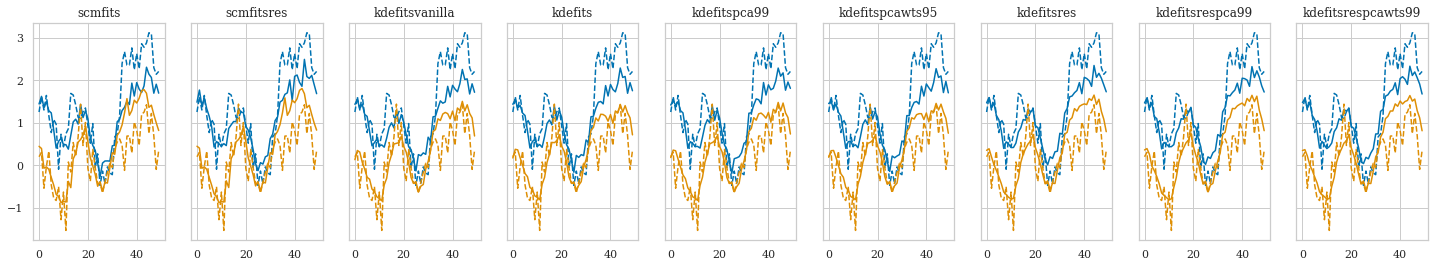

In [485]:
fig, ax = plt.subplots(1, 9, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

iis = [4, 9]
titles = ['scmfits', 'scmfitsres', 'kdefitsvanilla', 'kdefits', 'kdefitspca99', 
          'kdefitspcawts95', 'kdefitsres', 'kdefitsrespca99', 'kdefitsrespcawts99']
for j, fits in enumerate([scmfits, scmfitsres, kdefitsvanilla, kdefits, kdefitspca99,
                          kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
    axis = ax.flatten()[j]
    for i, ii in enumerate(iis): 
        axis.plot(fits[ii].pred, 'C%d'%i)
        axis.plot(fits[ii].treated, 'C%d--'%i)
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)

# GP

In [427]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*1# + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds
np.exp(-(((yy - xx.mean(axis=0))[:T0]**2).sum())/0.52**2), np.exp(-(((yyp - xx.mean(axis=0)[:T0])**2).sum())/0.52**2)

(9.962692091052866e-77, 1.15268838997904e-50)

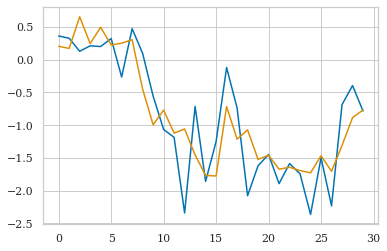

In [428]:
pcl = PCA(5).fit(xx[:, :T0])
yyp = pcl.inverse_transform(pcl.transform(yy[:T0].reshape(1, -1))).flatten()
# (pcl.explained_variance_ratio_).sum()
plt.plot(yy[:T0])
plt.plot(yyp)
# plt.plot(means)

RBF(length_scale=3.36)


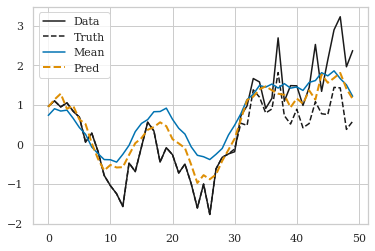

In [429]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*1# + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(1, [1e-1, 10]), n_restarts_optimizer=100, alpha=1e-10).fit(xxp[:, :T0], xxp[:, T0:])
# gp = GPR(kernels.Matern(10), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp *= stds
yp += means

plt.plot(treated, 'k-', label='Data')
plt.plot(truth, 'k--', label='Truth')
# plt.plot(xxc.T, alpha=0.2, color='b')
plt.plot(means, color='C0', label='Mean')
plt.plot(yp, 'C1--', label='Pred',lw=2)
plt.legend()

In [494]:

tools.approximate_rank(controls - controls.mean(axis=0), 0.7)

3

0.7365446810893878
0.8581921267852155
RBF(length_scale=5.21)


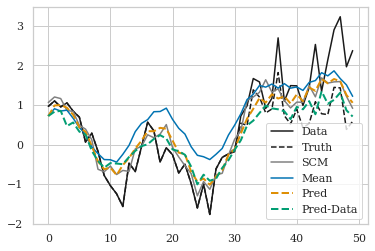

In [493]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*1# + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

ncomp = 3
pclpre = PCA(ncomp).fit(xx[:, :T0])
xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
print((pclpre.explained_variance_ratio_).sum())
pclpost = PCA(ncomp).fit(xx[:, T0:])
xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
print((pclpost.explained_variance_ratio_).sum())

alpha = (xx[:, :T0] - xxpre).std(axis=1)
gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
# gp = GPR(kernels.Matern(10), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yypre.reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp *= stds
yp += means

plt.plot(treated, 'k-', label='Data')
plt.plot(truth, 'k--', label='Truth')
# plt.plot(xxc.T, alpha=0.2, color='b')
plt.plot(synth.fit(controls, treated, T0)[0], color='gray', label='SCM')
plt.plot(means, color='C0', label='Mean')
plt.plot(yp, 'C1--', label='Pred',lw=2)
plt.plot(np.dot(wts, xxc), 'C2--', label='Pred-Data',lw=2)
plt.legend()

In [301]:
# gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
# gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
# wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))

# np.dot(gpkwts, gpalpha) /gp.predict(yy[:T0].reshape(1, -1))
# np.dot(wts, gp.y_train_)/gp.predict(yy[:T0].reshape(1, -1))

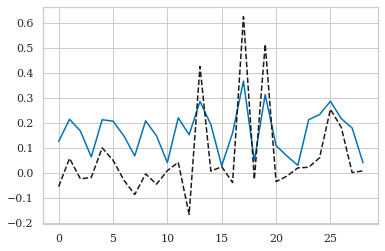

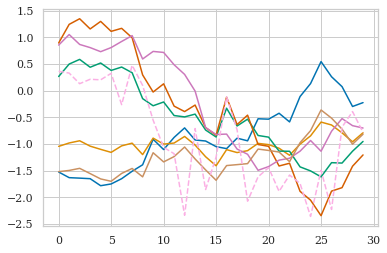

In [436]:
plt.plot(gpkwts/(gpkwts**2).sum()**0.5)
plt.plot(wts/(wts**2).sum()**0.5, 'k--')
plt.show()
wtspos = np.where(abs(wts) > 0.05)[0]
plt.plot(gp.X_train_[wtspos].T)
plt.plot(yy[:T0], '--')

In [490]:
kernel = kernels.RBF
kernel = kernels.Matern

    
gpfits = {}
# gpfitspca99, gpfitspca95, gpfitspca90, gpfitspca70 = {}, {}, {}, {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

 
    def getgppca(ddict, ncomp):
            if ncomp is not None:
                if ncomp == xx.shape[0] or ncomp == T0: ncomp -=1
                pclpre = PCA(ncomp).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncomp).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/100.

        #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = yp*stds + means
#             ypred = np.dot(wts, xxc)
            ypred = (np.dot(wts, xx))*stds + means
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
#             if ncomp is not None:            ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:            ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
    getgppca(gpfits, None)
    
#           
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)
    getgppca(gpfitspca99, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95) == ncomp:
        gpfitspca95[ss] = gpfitspca99[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95)
        getgppca(gpfitspca95, ncomp)
        
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90) == ncomp:
        gpfitspca90[ss] = gpfitspca95[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90)
        getgppca(gpfitspca90, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70) == ncomp:
        gpfitspca70[ss] = gpfitspca90[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70)
        getgppca(gpfitspca70, ncomp)
 

    


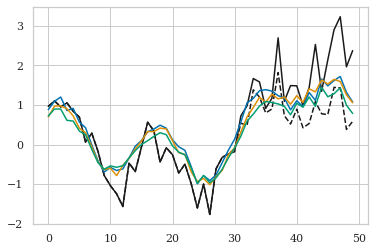

In [454]:
plt.plot(treated, 'k')
plt.plot(truth, 'k--')

plt.plot(gpfits[itreated].pred)
plt.plot(gpfitspca70[itreated].predp)
plt.plot(gpfitspca70[itreated].pred)
# plt.plot(gpfitspca90[itreated].pred)
# plt.plot(gpfitspca95[itreated].pred)
# plt.plot(gpfitspca99[itreated].pred)

In [ ]:
   
# gpfitspcawts99  =   {}


# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*1# + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds
    
#     #####
#     X1 = xx[:, :T0]
#     Y1 = yy[:T0]
# #     X2 = xx[:, T0:]
# #     Y2 = yy[T0:]
#     X2 = xx[:, :]
#     Y2 = yy[:]
#     #
#     nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
#     XX1 /= stds1
#     YY1 /= stds1
#     XX2 /= stds2
    
#     alpha = 0.01
#     gp = GPR(kernel(XX1.std(axis=0), length_scale_bounds=[0.01, 10.]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
#     yp = np.squeeze(gp.predict(YY1.reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
# #     yp = np.concatenate([p1.inverse_transform(stds1*np.dot(wts, gp.X_train_)), p2.inverse_transform(stds2*yp)])
#     yp = p2.inverse_transform(stds2*yp)
#     yp *= stds
#     yp += means

# #     ysample = np.squeeze(gp.sample_y(YY1.reshape(1, -1), 100))        
# #     ysample = ysample.T*stds[T0:]
# #     err = np.append(np.zeros(T0), ysample.std(axis=0))
#     gpfitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, nc1=nc1, nc2=nc2, pca1=p1, pca2=p2)
    
# gpfitspcawts99  =   {}

# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*1# + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds

    
#     #####
#     X1 = xx[:, :T0]
#     X2 = xx[:, T0:]
#     Y1 = yy[:T0]
#     Y2 = yy[T0:]
#     #
#     nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
#     XX1 /= stds1
#     YY1 /= stds1
#     XX2 /= stds2
    
#     alpha = 1e-10
#     gp = GPR(kernels.RBF(XX1.std(axis=0), length_scale_bounds=[0.01, 10.]),
#              n_restarts_optimizer=100, alpha=alpha).fit(XX1, XX2)
# #     gp = GPR(kernels.RBF(XX1.std(axis=0), length_scale_bounds=[XX1.std(axis=0).min()/3., XX1.std(axis=0).max()*3.]),
# #              n_restarts_optimizer=100, alpha=alpha).fit(XX1, XX2)
# #     gp = GPR(kernels.RBF(0.1, length_scale_bounds=[1e-2, 10]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
#     yp2 = np.squeeze(gp.predict(YY1.reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp1 = np.dot(wts, gp.X_train_)
# #     yp1 = YY1.flatten()
#     yp = np.concatenate([p1.inverse_transform(yp1*stds1), p2.inverse_transform(yp2*stds2)])
# #     yp = p2.inverse_transform(yp2*stds2)    
#     yp *= stds
#     yp += means

#     gpfitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, nc1=nc1, nc2=nc2, pca1=p1, pca2=p2)


    

# xplot = np.arange(X.shape[1])
# titles = ['SCM', 'KDE', 'GP',  'SCM - Resdiual', 'KDE - Residual',  'GP - Residual']
# for j, fits in enumerate([gpfitspcawts99]):
#     tmp = []
#     print(j, j//2 + j%2)
#     axis = plt.gca()
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
# #         if i  : tmp[-1][:T0] *= 0
# #         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
# #     axis.set_ylim(-100, 100)
#     axis.axhline(0, color='r', ls="--")


In [ ]:
# print(np.corrcoef(XX1[:, 0], XX2[:, 0])[1, 0])
# print(np.corrcoef(XX1[:, 0], XX2[:, 1])[1, 0])
# print(np.corrcoef(XX1[:, 1], XX2[:, 0])[1, 0])
# print(np.corrcoef(XX1[:, 1], XX2[:, 1])[1, 0])
# plt.plot(XX1[:, 0], XX2[:, 0], 'o')
# plt.plot(XX1[:, 0], XX2[:, 1], 'o')
# gpfitspcawts99[itreated].gp.kernel_

In [497]:
    
gpfitsres, gpfitspca99res, gpfitspca95res, gpfitspca90res, gpfitspca70res =  {}, {}, {}, {},{}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 #+ 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    xx -= mmx
    yy -= mmy

    ####
#
    def getgppcares(ddict, ncomp):
            if ncomp is not None:
                if ncomp >= xx.shape[0] or ncomp >= xx.shape[1]: ncc = ncomp - 1
                else: ncc = ncomp
                pclpre = PCA(ncc).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncc).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/100.
            #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = (yp + mmy)*stds + means
#             ypred = np.dot(wts, xxc)
            ypred = (np.dot(wts, xx) + mmy)*stds + means
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
            
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
            
    getgppcares(gpfitsres, None)
    
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)
    getgppcares(gpfitspca99res, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95) == ncomp:
        gpfitspca95res[ss] = gpfitspca99res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95)
        getgppcares(gpfitspca95res, ncomp)
        
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90) == ncomp:
        gpfitspca90res[ss] = gpfitspca95res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90)
        getgppcares(gpfitspca90res, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70) == ncomp:
        gpfitspca70res[ss] = gpfitspca90res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70)
        getgppcares(gpfitspca70res, ncomp)
        
        
# gpfitspcawts99res = {}

# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)*1
#     stds = xxc.std(axis=0)*1 #+ 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds
#     mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
#     xx -= mmx
#     yy -= mmy
#     #####
#     X1 = xx[:, :T0]
#     Y1 = yy[:T0]
# #     X2 = xx[:, T0:]
# #     Y2 = yy[T0:]
#     X2 = xx[:, :]
#     Y2 = yy[:]
    
#     #
#     nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
#     XX1 /= stds1
#     YY1 /= stds1
#     XX2 /= stds2
    
#     alpha = 0.001
#     gp = GPR(kernel(XX1.std(axis=0)/3., length_scale_bounds=[0.01, 10]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
#     yp = np.squeeze(gp.predict(YY1.reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp = p2.inverse_transform(yp*stds2)
# #     yp = np.concatenate([p1.inverse_transform(np.dot(wts, gp.X_train_)), p2.inverse_transform(yp)])
# #     yp = np.concatenate([Y1, p2.inverse_transform(yp)])
#     yp = (yp + mmy)*stds + means
#     gpfitspcawts99res[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca1=p1, pca2=p2, wts=wts, kwts=kwts)
     
    


scmfits
scmfits 0.5901373775998738
scmfitsres
scmfitsres 0.6343822638181441
 pcafits99
 pcafits99 1.0415628605462466
pcafits99reg
pcafits99reg 0.7694123027910648
pcafitsyj99
pcafitsyj99 0.5915739686315005
pcafits95
pcafits95 0.8611802558322335
pcafits95reg
pcafits95reg 0.6863015169627259
pcafitsyj95
pcafitsyj95 116.87443562373156
kdefitspca99 0.5107360606174414
kdefitsres 0.5642683506750831
kdefitsrespca99 0.5362354719932333
gpfits 0.5357446565597868
gpfitspca90 0.533041881095408
gpfitspca70 0.5277016686889479
gpfitsres 0.608707517691539
gpfitspca90res 0.6020474236326087
gpfitspca70res 0.5733226825869717


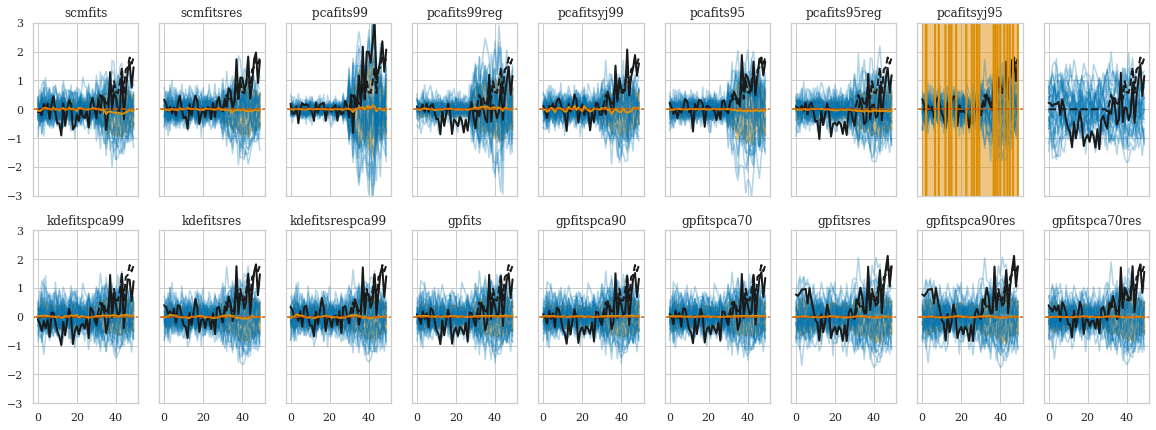

In [499]:
fig, ax = plt.subplots(2, 9, figsize=(20, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = 'scmfits, scmfitsres,  pcafits99, pcafits99reg, pcafitsyj99, pcafits95, pcafits95reg, pcafitsyj95'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres,  pcafits99, pcafits99reg, pcafitsyj99, pcafits95, pcafits95reg, pcafitsyj95]):
    print(titles[j])
    tmp = []
    axis = ax[0].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, X[itreated] - cf[itreated], 'k--', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.axhline(0, color='r', ls="--")

    
# titles = 'kdefitspca99, kdefitsres, kdefitsrespca99, gpfits, gpfitspca99, gpfitspca95, gpfitsres, gpfitspca99res, gpfitspcawts95res'
titles = 'kdefitspca99, kdefitsres, kdefitsrespca99, gpfits, gpfitspca90, gpfitspca70, gpfitsres, gpfitspca90res, gpfitspca70res'
titles = titles.split(', ')
# for j, fits in enumerate([kdefitspca99, kdefitsres, kdefitsrespca99, gpfits, gpfitspca99, gpfitspcawts99, gpfitsres, gpfitspca99res, gpfitspcawts99res]):
for j, fits in enumerate([kdefitspca99, kdefitsres, kdefitsrespca99, gpfits, gpfitspca99, gpfitspca95, gpfitsres, gpfitspca99res, gpfitspca95res]):
# for j, fits in enumerate([kdefitspca99, kdefitsres, kdefitsrespca99, gpfits, gpfitspca90, gpfitspca70, gpfitsres, gpfitspca90res, gpfitspca70res]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        try: tmp.append(fits[ii].treated - fits[ii].pred)
        except: tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, X[itreated] - cf[itreated], 'k--', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-3, 3)
#     axis.set_ylim(-25, 25)
    axis.axhline(0, color='r', ls="--")


axis = ax[0, -1]
for ii in range(X.shape[0]): 
    axis.plot(xplot, fits[ii].treated - controls.mean(axis=0), 'C0', alpha=0.3)
axis.plot(xplot, X[itreated] - cf[itreated], 'k--', lw=2)
axis.plot(xplot, X[itreated] - controls.mean(axis=0), 'k-', lw=2)
    

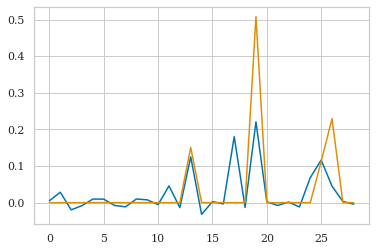

In [501]:
# plt.plot(scmfits[0].wts)
# plt.plot(gpfits[0].kwts)
plt.plot(gpfits[0].wts)
plt.plot(scmfits[0].wts)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = t.copy()
    
titles = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  scmfitsres, pcafits95,  pcafitsyj95, kdefitsres, gpfitsres]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
#         if i  : tmp[-1][:T0] *= 0
#         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, X[itreated] - cf[itreated], 'k--', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
    axis.axhline(0, color='r', ls="--")
#     axis.axvline(years[T0], color='r', ls="--")
# plt.savefig('../new_figs/basque_all95.png')

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(t, scmfitsres[itreated].controls.mean(axis=0), 'gray')
plt.plot(t, scmfitsres[itreated].treated, 'k-')
plt.plot(t, cf[itreated], 'k--')
plt.plot(t, scmfits[itreated].pred, '--', label='SCM')
plt.plot(t, scmfitsres[itreated].pred, '--', label='SCM Res')
plt.plot(t, pcafits99[itreated].pred, '--', label='PCR')
plt.plot(t, pcafitsyj99[itreated].pred, label='Prob PCR')
plt.plot(t, kdefitsres[itreated].pred, label='KDE')
plt.errorbar(t, gpfitsres[itreated].pred, gpfitsres[itreated].err, label='GPR')
plt.legend()

# Save

In [142]:
import os

In [522]:
# ofolder = '../tmpdata/sinecos_c2_s2_ranload_ranphase/'
# try : os.makedirs(ofolder)
# except Exception as e: print(e)
# print(ofolder)

# np.save(ofolder + 'data.npy', X)
# np.save(ofolder + 'cf.npy', cf)

# titles = ['scmfits','scmfitsres']
# for j, fits in enumerate([scmfits,  scmfitsres]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save(ofolder + '%s'%titles[j], tosave)
    
# titles = 'pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save(ofolder + '%s'%titles[j], tosave)

# titles = 'kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99'
# titles = titles.split(', ')
# for j, fits in enumerate([kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save(ofolder + '%s'%titles[j], tosave)

# titles = 'gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspcawts99, gpfitspcawts99res, gpfitspcawts99res'
# titles = 'gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res, gpfitspca90, gpfitspca90res, gpfitspca70, gpfitspca70res'
# titles = titles.split(', ')
# # for j, fits in enumerate([gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspcawts99, gpfitspcawts99res, gpfitspcawts99res]):
# for j, fits in enumerate([gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res, gpfitspca90, gpfitspca90res, gpfitspca70, gpfitspca70res]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     np.save(ofolder + '%s'%titles[j], tosave)

# titles = 'pcapreds, pcapredsreg, pcapredsyj, svdpreds'
# titles = titles.split(', ')
# for j, fits in enumerate([pcapreds, pcapredsreg, pcapredsyj, svdpreds]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in ncomps]) #ange(1, 11)])
#     np.save(ofolder + '%s'%titles[j], tosave)
#     np.save(ofolder + 'ncomps', ncomps)


../tmpdata/sinecos_c2_s2_ranload_ranphase/


In [525]:
str(dgpdict)

"{'seed': 100, 'cos': [0.5, 1.0], 'sine': [0.3, 0.8], 'loadings': 'random', 'noise': 0.3, 'monoamp': 1, 'fix': 1, 'phases': 'random'}"

In [526]:
# with open(ofolder + 'dgpdict.txt', 'w') as f:
#     f.write(str(dgpdict))

## plot

In [61]:
# nrow =  5
# ncol = 5
# irs = np.sort(np.random.permutation(np.arange(N))[:nrow*ncol-1])
# fig, axar = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3.2),
#                          sharex=True, sharey=True)
# ax = axar.flatten()

# for jj, ss in enumerate(irs):
#     ii = jj + 1
#     xx = pcafits[ss].controls
#     means, stds = xx.mean(axis=0), xx.std(axis=0)
#     yy = pcafits[ss].treated
    
#     ax[ii].plot(years, means, 'k--')
#     ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
#     ax[ii].plot(years, yy, 'k', lw=2)
    
#     ax[ii].plot(years, scmfits[ss].pred, 'k:')
#     ax[ii].plot(years, pcafits[ss].pred, 'C0-')
#     ax[ii].plot(years, pcafits3[ss].pred, 'C0--')
#     ax[ii].plot(years, pcafitsyj[ss].pred, 'C1-')
# #     ax[ii].plot(years, pcafitsyj3[ss].pred, 'C1--')
    
# #     ax[ii].plot(years, svdfitsfits[ss].pred, 'C3-')
# #     ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C3--')
# #     ax[ii].plot(years, svdfitsfitsc3[ss].pred, 'C3:', lw=2)
    
#     ax[ii].plot(years, kdefits[ss].pred, 'C4-')
#     ax[ii].plot(years, kdefitspca99[ss].pred, 'C4--')
#     ax[ii].plot(years, kdefitsres[ss].pred, 'C4:', lw=2)

#     ax[ii].plot(years, gpfits[ss].pred, 'C7-')
#     ax[ii].plot(years, gpfitspca99[ss].pred, 'C7--')
#     ax[ii].plot(years, gpfitsres[ss].pred, 'C7:', lw=2)
#     ax[ii].set_title(ss, fontsize=12)
    
# ss = itreated
# ii=0
# xx = pcafits[ss].controls
# means, stds = xx.mean(axis=0), xx.std(axis=0)
# yy = pcafits[ss].treated
# yp = synth.fit(xx, yy, T0)[0]

# ax[ii].plot(years, means, 'k--')
# ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
# ax[ii].plot(years, yy, 'k', label='Data', lw=2)

# ax[ii].plot(years, scmfits[ss].pred, 'k:', label='SCM')
# ax[ii].plot(years, pcafits[ss].pred, 'C0-', label='PCA')
# ax[ii].plot(years, pcafits3[ss].pred, 'C0--', label='PCA3')
# ax[ii].plot(years, pcafitsyj[ss].pred, 'C1-', label='PCA-YJ')
# # ax[ii].plot(years, pcafitsyj3[ss].pred, 'C1--', label='PCA-YJ3')
# # ax[ii].plot(years, svdfitsfits[ss].pred, 'C3-', label='SVD')
# # ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C3--', label='SVD-C')
# # ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C3:', label='SVD-C3')
# ax[ii].plot(years, kdefits[ss].pred, 'C4-', label='KDE')
# ax[ii].plot(years, kdefitspca99[ss].pred, 'C4--', label='KDE-PCA')
# ax[ii].plot(years, kdefitsres[ss].pred, 'C4:', label='KDE-PCA3')
# ax[ii].plot(years, gpfits[ss].pred, 'C7-', label='GP')
# ax[ii].plot(years, gpfitspca99[ss].pred, 'C7--', label='GP-PCA')
# ax[ii].plot(years, gpfitsres[ss].pred, 'C7:', label='GP-PCA3', lw=2)
# ax[ii].set_title(ss, fontsize=12)
# ax[ii].legend(ncol=8, fontsize=13, loc=3, bbox_to_anchor=(0, 1.05))

# for axis in ax:
# #     axis.set_xlim(1969, 2005)
#     axis.set_ylim(-50, 200)
# #     axis.axvline(1988, color='c', ls='--')
#     ax[0].legend(ncol=6, bbox_to_anchor=(4.5, 1.3), fontsize=12)
    
# plt.show()

In [ ]:
# for ss in [itreated]:
#     w1, w2 = kdefits[ss].wts.flatten(), scmfits[ss].wts.flatten()
#     w1 /= w1.sum()
#     w2 /= w2.sum()
#     w1[w1<0.01] = 0
#     w2[w2<0.01] = 0
#     print(ss, np.corrcoef(w1, w2)[0, 1])
    
#     fig, ax = plt.subplots(1,1, figsize=(8, 5))
#     ax = [ax]
#     ii=0
#     ax[ii].plot(years, scmfits[ss].treated, 'k',lw=2, label='Data')

#     ax[ii].plot(years, scmfits[ss].pred, 'k:', label='SCM')

#     ax[ii].plot(years, svdfitsfits[ss].pred, 'C0-', label='SVD')
#     ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C0--', lw=2, label='SVD-C')
#     ax[ii].plot(years, svdfitsfitsc3[ss].pred, 'C0:', lw=2, label='SVD-C3')

#     ax[ii].plot(years, kdefits[ss].pred, 'C1-', label='KDE')
#     ax[ii].plot(years, kdefitspca[ss].pred, 'C1--', label='KDE-PCA')
#     ax[ii].plot(years, kdefitspca3[ss].pred, 'C1:', label='KDE-PCA3')
    

#     ax[ii].plot(years, pcafits[ss].pred, 'C2', label='PCA')
#     ax[ii].plot(years, pcafits3[ss].pred, 'C2--', label='PCA-3')
#     ax[ii].plot(years, pcafitsyj[ss].pred, 'C4', label='PCA-YJ')
#     ax[ii].plot(years, pcafitsyj3[ss].pred, 'C4--', label='PCA-YJ-3')
    
#     ax[ii].errorbar(years, gpfits[ss].pred, gpfits[ss].err, color='C7', label='GP', elinewidth=0.5)
    
#     ax[ii].errorbar(years+0.25, gpfitspca[ss].pred, gpfitspca[ss].err, color='C9', ls="-", lw=1, elinewidth=0.5, label='GP-PCA')
#     ax[ii].errorbar(years-0.25, gpfitspca3[ss].pred, gpfitspca3[ss].err, color='C9', ls="--",  lw=2, elinewidth=0.5, label='GP-PCA3')

# plt.legend(loc=2, bbox_to_anchor=(1, 1))
# plt.axvline(T0, color='k', ls="--")
# # plt.xlim(1970, 2005)
# # plt.ylim(0, 200)

In [63]:
# diffscm  = np.zeros_like(controls)
# diffsvd, diffsvdc, diffsvdc3  = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
# diffkde, diffkdepca, diffkdepca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
# diffpca, diffpca3, diffpcayj, diffpcayj3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
# diffgp, diffgppca, diffgppca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)

# for ii, ss in enumerate(np.arange(N-1)):
#     if ii == itreated: continue
#     xx = pcafits[ss].controls
#     means, stds = xx.mean(axis=0), xx.std(axis=0)
#     yy = pcafits[ss].treated

#     diffscm[ii] = (yy-scmfits[ss].pred)

#     diffpca[ii] = (yy-pcafits[ss].pred)
#     diffpcayj[ii] = (yy-pcafitsyj[ss].pred)    
#     diffpca3[ii] = (yy-pcafits3[ss].pred)
# #     diffpcayj3[ii] = (yy-pcafitsyj3[ss].pred)
    
# #     diffsvd[ii] = (yy-svdfitsfits[ss].pred)
# #     diffsvdc[ii] = (yy-svdfitsfitsc[ss].pred)
# #     diffsvdc3[ii] = (yy-svdfitsfitsc3[ss].pred)
    
#     diffkde[ii] = (yy-kdefits[ss].pred)
#     diffkdepca[ii] = (yy-kdefitspca[ss].pred)
#     diffkdepca3[ii] = (yy-kdefitspca3[ss].pred)
    
#     diffgp[ii] = (yy-gpfits[ss].pred)
#     diffgppca[ii] = (yy-gpfitspca[ss].pred)
#     diffgppca3[ii] = (yy-gpfitspca3[ss].pred)


In [ ]:



# tmpy = pcafits[itreated].treated

# fig, axar = plt.subplots(3, 5, figsize=(20, 14), sharex=True, sharey=True)
# ax = axar.flatten()

# dd = diffscm.copy()
# ax[0].plot(years, dd.T, 'C0-', alpha=0.5)
# ax[0].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
# ax[0].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
# ax[0].plot(years, tmpy - scmfits[itreated].pred, 'k-', alpha=1)
# ax[0].set_title('SCM')
# ax[0].set_ylabel("Data - Pred")


# def tmpplot(ii, title, dd, ddca):
#     ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
#     ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
#     ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
#     ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
#     ax[ii].set_title(title)

# ii, title, dd, ddca = 1, 'SVD', diffsvd.copy(), svdfitsfits[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 2, 'SVD-center', diffsvdc.copy(), svdfitsfitsc[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 3, 'SVD-center3', diffsvdc3.copy(), svdfitsfitsc3[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 4, 'KDE', diffkde.copy(), kdefits[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 5, 'KDE-PCA', diffkdepca.copy(), kdefitspca[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 6, 'KDE-PCA3', diffkdepca3.copy(), kdefitspca3[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 7, 'PCA', diffpca.copy(), pcafits[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 8, 'PCA-YJ', diffpcayj.copy(), pcafitsyj[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 9, 'PCA-3', diffpca3.copy(), pcafits3[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 10, 'PCA-YJ3', diffpcayj3.copy(), pcafitsyj3[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 11, 'GP', diffgp.copy(), gpfits[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 12, 'GP-PCA', diffgppca.copy(), gpfitspca[itreated].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 13, 'GP-PCA3', diffgppca3.copy(), gpfitspca3[itreated].pred
# tmpplot(ii, title, dd, ddca)

# for axis in ax:
# #     axis.set_xlim(1969, 2005)
#     axis.set_ylim(-100, 200)
#     axis.axvline(T0, color='r', ls='--')
